# Step By Step Matching verstehen!!!!
# Alle Steps Plotten!
# Warum entfallen bei steileren Elevationswinkel die Messungen ????!!!!

In [1]:
import warnings
warnings.filterwarnings('ignore')
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [2]:
# define GPM data set
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007-S015721-E032951.003445.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S084747-E102017.003465.V05A.HDF5'
#gpm_file = wrl.util.get_wradlib_data_file(gpm_file_path)



#gpm_file = wrl.util.get_wradlib_data_file('/user/velibor/SHKGPM/Australien-gpm/volmatch/GPM_example/2A-RW-BRS.GPM.Ku.V6-20160118.20141206-S095002-E095137.004383.V04A.HDF5')
gpm_file = wrl.util.get_wradlib_data_file('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141206-S083332-E100603.004383.V05A.HDF5')
# define matching ground radar file
#gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_280deg/2014-10-08--09:45:00,00.mvol'
#gr2gpm_file = wrl.util.get_wradlib_data_file(gr_file_path)

gr2gpm_file = wrl.util.get_wradlib_data_file('/user/velibor/SHKGPM/Australien-gpm/volmatch/GPM_example/IDR66_20141206_094829.vol.h5')



In [3]:
print (gr2gpm_file)
print (gpm_file)

/user/velibor/SHKGPM/Australien-gpm/volmatch/GPM_example/IDR66_20141206_094829.vol.h5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141206-S083332-E100603.004383.V05A.HDF5


In [4]:
# Space-born precipitation radar parameters
sr_pars = {"gpm": {
    "zt": 407000.,  # orbital height of GPM                 APPROXIMATION!
    "dr": 125.,      # gate spacing of GPM
    "gr_file": gr2gpm_file,
}}

In [5]:
# Set parameters for this procedure
bw_sr = 0.71                  # SR beam width
platf = "gpm"                 # SR platform/product: one out of ["gpm", "trmm"]
zt = sr_pars[platf]["zt"]     # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)
gr_file = sr_pars[platf]["gr_file"]




In [6]:
def _get_tilts(dic):
    i = 0
    for k in dic.keys():
        if 'dataset' in k:
            i += 1
    return i


def read_gr(filename, loaddata=True):

    gr_data = wrl.io.read_generic_netcdf(filename)
    dat = gr_data['what']['date']
    tim = gr_data['what']['time']
    date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
    source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    if gr_data['what']['object'] == 'PVOL':
        ntilt = _get_tilts(gr_data)
    else:
        raise ValueError('GR file is no PPI/Volume File')

    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)

    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        a0[i] = dset['how']['astart']
        elang[i] = dset['where']['elangle']
        ngate[i] = dset['where']['nbins']
        r0[i] = dset['where']['rstart']
        dr[i] = dset['where']['rscale']
        nbeam[i] = dset['where']['nrays']

    if ((len(np.unique(r0)) != 1) |
            (len(np.unique(dr)) != 1) |
            (len(np.unique(a0)) != 1) |
            (len(np.unique(nbeam)) != 1) |
            (nbeam[0] != 360)):
        raise ValueError('GroundRadar Data layout dos not match')

    gr_dict = {}
    gr_dict.update({'source': source, 'date': date, 'lon': lon, 'lat': lat,
                    'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                    'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
    if not loaddata:
        return gr_dict

    sdate = []
    refl = []
    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        dat = dset['what']['startdate']
        tim = dset['what']['starttime']
        date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
        sdate.append(date)
        data = dset['data1']
        quantity = data['what']['quantity']
        factor = data['what']['gain']
        offset = data['what']['offset']
        if quantity == 'DBZH':
            dat = data['variables']['data']['data'] * factor + offset
            refl.append(dat)

    sdate = np.array(sdate)
    refl = np.array(refl)

    gr_dict.update({'sdate': sdate, 'refl': refl})

    return gr_dict

def read_gpm(filename, bbox):
    pr_data = Dataset(filename, mode="r")
    lon = pr_data['NS'].variables['Longitude']
    lat = pr_data['NS'].variables['Latitude']

    poly = [[bbox['left'], bbox['bottom']],
            [bbox['left'], bbox['top']],
            [bbox['right'], bbox['top']],
            [bbox['right'], bbox['bottom']],
            [bbox['left'], bbox['bottom']]]
    mask = get_clip_mask(np.dstack((lon[:], lat[:])), poly)
    mask = np.nonzero(np.count_nonzero(mask, axis=1))
    lon = lon[mask]
    lat = lat[mask]

    year = pr_data['NS']['ScanTime'].variables['Year'][mask]
    month = pr_data['NS']['ScanTime'].variables['Month'][mask]
    dayofmonth = pr_data['NS']['ScanTime'].variables['DayOfMonth'][mask]
    # dayofyear = pr_data['NS']['ScanTime'].variables['DayOfYear'][mask]
    hour = pr_data['NS']['ScanTime'].variables['Hour'][mask]
    minute = pr_data['NS']['ScanTime'].variables['Minute'][mask]
    second = pr_data['NS']['ScanTime'].variables['Second'][mask]
    # secondofday = pr_data['NS']['ScanTime'].variables['SecondOfDay'][mask]
    millisecond = pr_data['NS']['ScanTime'].variables['MilliSecond'][mask]
    date_array = zip(year, month, dayofmonth,
                     hour, minute, second,
                     millisecond.astype(np.int32) * 1000)
    pr_time = np.array(
        [dt.datetime(d[0], d[1], d[2], d[3], d[4], d[5], d[6]) for d in
         date_array])

    sfc = pr_data['NS']['PRE'].variables['landSurfaceType'][mask]
    pflag = pr_data['NS']['PRE'].variables['flagPrecip'][mask]

    # bbflag = pr_data['NS']['CSF'].variables['flagBB'][mask]
    zbb = pr_data['NS']['CSF'].variables['heightBB'][mask]
    # print(zbb.dtype)
    bbwidth = pr_data['NS']['CSF'].variables['widthBB'][mask]
    qbb = pr_data['NS']['CSF'].variables['qualityBB'][mask]
    qtype = pr_data['NS']['CSF'].variables['qualityTypePrecip'][mask]
    ptype = pr_data['NS']['CSF'].variables['typePrecip'][mask]

    quality = pr_data['NS']['scanStatus'].variables['dataQuality'][mask]
    refl = pr_data['NS']['SLV'].variables['zFactorCorrected'][mask]
    # print(pr_data['NS']['SLV'].variables['zFactorCorrected'])

    zenith = pr_data['NS']['PRE'].variables['localZenithAngle'][mask]

    pr_data.close()

    # Check for bad data
    if max(quality) != 0:
        raise ValueError('GPM contains Bad Data')

    pflag = pflag.astype(np.int8)

    # Determine the dimensions
    ndim = refl.ndim
    if ndim != 3:
        raise ValueError('GPM Dimensions do not match! '
                         'Needed 3, given {0}'.format(ndim))

    tmp = refl.shape
    nscan = tmp[0]
    nray = tmp[1]
    nbin = tmp[2]

    # Reverse direction along the beam
    refl = np.flip(refl, axis=-1)

    # Change pflag=1 to pflag=2 to be consistent with 'Rain certain' in TRMM
    pflag[pflag == 1] = 2

    # Simplify the precipitation types
    ptype = (ptype / 1e7).astype(np.int16)

    # Simplify the surface types
    imiss = (sfc == -9999)
    sfc = (sfc / 1e2).astype(np.int16) + 1
    sfc[imiss] = 0

    # Set a quality indicator for the BB and precip type data
    # TODO: Why is the `quality` variable overwritten?

    quality = np.zeros((nscan, nray), dtype=np.uint8)

    i1 = ((qbb == 0) | (qbb == 1)) & (qtype == 1)
    quality[i1] = 1

    i2 = ((qbb > 1) | (qtype > 2))
    quality[i2] = 2

    gpm_data = {}
    gpm_data.update({'nscan': nscan, 'nray': nray, 'nbin': nbin,
                     'date': pr_time, 'lon': lon, 'lat': lat,
                     'pflag': pflag, 'ptype': ptype, 'zbb': zbb,
                     'bbwidth': bbwidth, 'sfc': sfc, 'quality': quality,
                     'refl': refl, 'zenith': zenith})

    return gpm_data


In [7]:
def read_gr_boxpol(filename, loaddata=True):
    """
    Read ground radar boxpol scans
    
    in arbeit....
    zur zeit nur ein scan (1.5)
    """
    sdate = []
    refl = []
    
    gr_data = wrl.io.read_generic_netcdf(gr_file)
    grdata, grattrs = wrl.io.read_GAMIC_hdf5(gr_file)
    print gr_file
    
    dat_ = gr_data['what']['date']
    print dat_
    dat = dat_[0:10]
    tim = dat_[11:-1]
    print (dat, tim)
    # '2014-10-07T02:42:02Z'
    date = dt.datetime.strptime(dat + tim, "%Y-%d-%m%H:%M:%S")
    #source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    import glob
    c_liste = glob.glob(gr_file.replace('n_ppi_010deg','*ppi*'))
    ntilt = len(c_liste)
    
    ref_data = [[]]*ntilt


    print ('ntilit:',ntilt)    
    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)
    
    for jj in range(ntilt):
        print c_liste[jj]
        
        gr_data = wrl.io.read_generic_netcdf(c_liste[jj])
        grdata, grattrs = wrl.io.read_GAMIC_hdf5(c_liste[jj])

        #for i in range(0, ntilt):
        dset = gr_data['scan0']
        # Azimuth Start
        a0[jj] = dset['how']['azi_start'] 
        # Elevations Winkel
        elang[jj] = dset['how']['elevation']
        # Anzahl bins
        ngate[jj] = dset['how']['bin_count']
        # Start und Step der range
        r0[jj] = dset['how']['range_start']
        dr[jj] = dset['how']['range_step'] * dset['how']['range_samples']
        # Anzahl Rays
        nbeam[jj] = dset['how']['ray_count']

        print ('azi start: ', a0)    
        print ('elevation: ', elang)    
        print ('bin count: ', ngate)    
        print ('range start: ', r0)    
        print ('range step: ', dr)    
        print ('ray count: ', nbeam)    


        gr_dict = {}
        gr_dict.update({'date': date, 'lon': lon, 'lat': lat,
                        'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                        'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
        if not loaddata:
            return gr_dict



        #for i in range(0, ntilt):
            #dset = gr_data['scan0']
            #data = dset['variables']['moment_10']['data']

        data = grdata['SCAN0']['ZH']['data']
        

        #refl.append(data)
        ref_data[jj]=data

        #refl1 = np.array(refl)
    gr_dict.update({'refl': ref_data})
    
    return gr_dict



In [8]:
# read matching GR data
gr_data = read_gr(gr_file)


In [9]:

for i in range(len(gr_data.keys())):
    print (gr_data.keys()[i])
    print(gr_data[gr_data.keys()[i]])
    print ('------------------------- \n \n \n')
    

elang
[ 0.5         0.89999998  1.29999995  1.79999995  2.4000001   3.0999999
  4.19999981  5.5999999   7.4000001  10.         13.30000019 17.89999962
 23.89999962 32.        ]
------------------------- 
 
 

sdate
[datetime.datetime(2014, 6, 12, 9, 48, 29)
 datetime.datetime(2014, 6, 12, 9, 49, 2)
 datetime.datetime(2014, 6, 12, 9, 49, 31)
 datetime.datetime(2014, 6, 12, 9, 49, 58)
 datetime.datetime(2014, 6, 12, 9, 50, 20)
 datetime.datetime(2014, 6, 12, 9, 50, 37)
 datetime.datetime(2014, 6, 12, 9, 50, 54)
 datetime.datetime(2014, 6, 12, 9, 51, 11)
 datetime.datetime(2014, 6, 12, 9, 51, 28)
 datetime.datetime(2014, 6, 12, 9, 51, 45)
 datetime.datetime(2014, 6, 12, 9, 52, 2)
 datetime.datetime(2014, 6, 12, 9, 52, 20)
 datetime.datetime(2014, 6, 12, 9, 52, 38)
 datetime.datetime(2014, 6, 12, 9, 52, 56)]
------------------------- 
 
 

r0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
------------------------- 
 
 

source
RAD:AU66,PLC:MtStapl
------------------------- 
 
 

nbeam
[360. 3

In [10]:
######### GR data and att
ee = 12
# number of rays in gr sweep
nray_gr = gr_data['nbeam'].astype("i4")[ee]
# number of gates in gr beam
ngate_gr = gr_data['ngate'].astype("i4")[ee]
# number of sweeps
nelev = gr_data['ntilt']
# elevation of sweep (degree)
elev_gr = gr_data['elang'][ee]
# gate length (meters)
dr_gr = gr_data['dr'][ee]
# reflectivity array of sweep
ref_gr = gr_data['refl'][ee]
# sweep datetime stamp
#date_gr = gr_data['sdate'][ee]
# range of first gate
r0_gr = gr_data['r0'][ee]
# azimuth angle of first beam
a0_gr = gr_data['a0'][ee]
# Longitude of GR
lon0_gr = gr_data['lon']
# Latitude of GR
lat0_gr = gr_data['lat']
# Altitude of GR (meters)
alt0_gr = gr_data['alt']
# Beam width of GR (degree)
bw_gr = 1.
print(ee, nray_gr, ngate_gr, nelev, elev_gr, dr_gr, r0_gr, a0_gr )
print(lon0_gr, lat0_gr, alt0_gr)

print(ref_gr.shape)
##############
##############
### synthetic#
##############
##############
#ref_gr = np.ones(ref_gr.shape)*40

(12, 360, 600, 14, 23.899999618530273, 250.0, 0.0, -0.5)
(153.24000549316406, -27.71809959411621, 174.99999701976776)
(360, 600)


In [11]:
#Umwandlung GR in coordinaten Lon Lat Alt
coord = wrl.georef.sweep_centroids(nray_gr, dr_gr, ngate_gr, elev_gr)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      np.degrees(coord[..., 1]),
                                      coord[..., 2],
                                      (lon0_gr, lat0_gr, alt0_gr))
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]
bbox = wrl.zonalstats.get_bbox(lon, lat)
print("Radar bounding box:\n\t%.2f\n%.2f           %.2f\n\t%.2f" %
      (bbox['top'], bbox['left'], bbox['right'], bbox['bottom']))


Radar bounding box:
	-26.49
151.86           154.62
	-28.95


In [13]:
bbox = wrl.zonalstats.get_bbox(lon, lat)

151.86052484244263

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


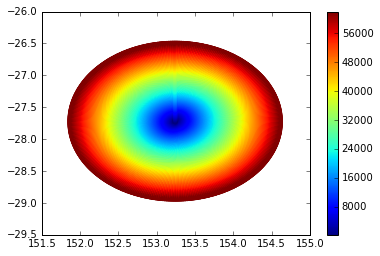

In [12]:
# Testbox
pl.scatter(lon,lat,c=alt, edgecolors='none')
pl.colorbar()


In [13]:
# read spaceborn SR data
#if platf == "gpm":
#    sr_data = wrl.io.read_gpm(gpm_file, bbox)
#elif platf == "trmm":
#    sr_data = wrl.io.read_trmm(trmm_2a23_file, trmm_2a25_file, bbox)
#else:
#    raise("Invalid platform")
sr_data = wrl.io.read_gpm(gpm_file, bbox)


(74, 49, 176)


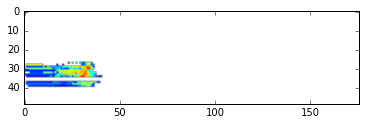

In [14]:
refl = sr_data['refl']
print refl.shape
pl.imshow(refl[20,:,:])



In [15]:
# Longitudes of SR scans
sr_lon = sr_data['lon']
# Latitudes of SR scans
sr_lat = sr_data['lat']
# Precip flag
pflag = sr_data['pflag']

##############
##############
### synthetic#
##############
##############
#pflag = np.ones(pflag.shape)*2

# Number of scans on SR data
nscan_sr= sr_data['nscan']
# Number of rays in one SR scan
nray_sr = sr_data['nray']
# Number of gates in one SR ray
ngate_sr = sr_data['nbin']

print (sr_lon.shape, refl.shape)
print ('SR Scan: ',nscan_sr)
print ('SR Ray: ',nray_sr)
print ('SR Gate: ',ngate_sr)

((74, 49), (74, 49, 176))
('SR Scan: ', 74)
('SR Ray: ', 49)
('SR Gate: ', 176)


In [16]:
# Calculate equivalent earth radius
wgs84 = wrl.georef.get_default_projection()
re1 = wrl.georef.get_earth_radius(lat0_gr, wgs84)
print("Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)

# Set up aeqd-projection gr-centered
rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))
re2 = wrl.georef.get_earth_radius(lat0_gr, rad)
print("Earth radius 2:", re2)

#print('rad: ', rad)

('Earth radius 1:', 6373541.039814419)
('SemiMajor, SemiMinor:', 6378137.0, 6356752.314245179)
('Earth radius 2:', 6373541.039814381)


('Range/Azi-Shape:', (600,), (360,))
-------------------

('Max Range/Azi:', 149875.0, 359.5)
('Min Range/Azi:', 125.0, 0.5)
-------------------

('XYZ-Grid-Shape:', (360, 600, 3))
((216000, 5, 3), '------')
('Domain-Shape:', (361, 2))


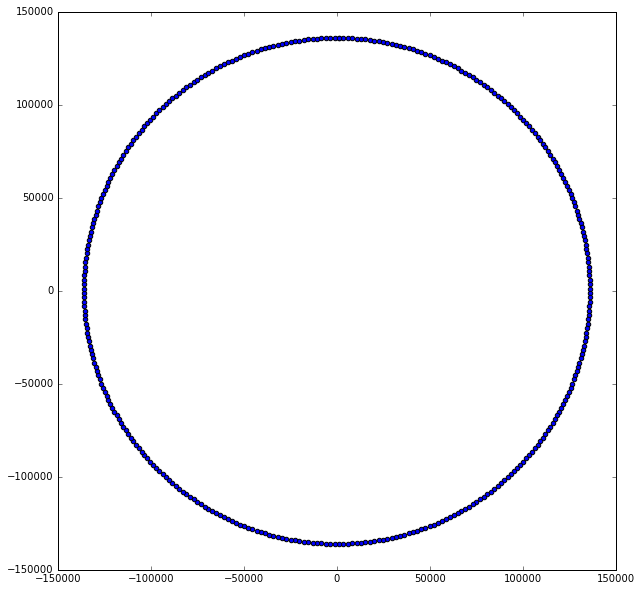

In [17]:
# create gr range and azimuth arrays
rmax_gr = r0_gr + ngate_gr * dr_gr
r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
az_gr = np.arange(0, nray_gr) - a0_gr
print("Range/Azi-Shape:", r_gr.shape, az_gr.shape)
print('-------------------\n')
print("Max Range/Azi:", np.nanmax(r_gr), np.nanmax(az_gr))
print("Min Range/Azi:", np.nanmin(r_gr), np.nanmin(az_gr))
print('-------------------\n')


# create gr polar grid and calculate aeqd-xyz coordinates
gr_polargrid = np.meshgrid(r_gr, az_gr)
gr_xyz, rad = wrl.georef.spherical_to_xyz(gr_polargrid[0], gr_polargrid[1], elev_gr, (lon0_gr, lat0_gr, alt0_gr ))
print("XYZ-Grid-Shape:", gr_xyz.shape)

#pl.figure(figsize=(10,10))
#pl.scatter(gr_xyz[...,0], gr_xyz[...,1], c=gr_xyz[...,2],edgecolors='none')
#pl.colorbar()

# create gr poygon array in aeqd-xyz-coordinates
gr_poly, rad1 = wrl.georef.spherical_to_polyvert(r_gr, az_gr, elev_gr, (lon0_gr, lat0_gr, alt0_gr))
print(gr_poly.shape, '------')
gr_poly.shape = (nray_gr, ngate_gr, 5, 3)


# get radar domain (outer ring)
gr_domain = gr_xyz[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))
print("Domain-Shape:", gr_domain.shape)

pl.figure(figsize=(10,10))
pl.scatter(gr_domain[...,0], gr_domain[...,1])


('SR-GRID-Shapes:', (74, 49), (74, 49), (74, 49, 2))


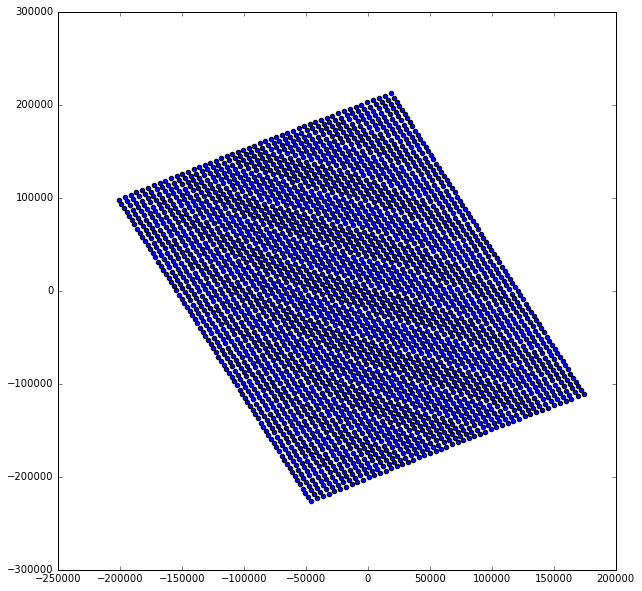

In [18]:
# SR Koordinaten LonLat -> XY
sr_x, sr_y = wrl.georef.reproject(sr_lon, sr_lat,
                                      projection_source=wgs84,
                                      projection_target=rad)
sr_xy = np.dstack((sr_x, sr_y))
print("SR-GRID-Shapes:", sr_x.shape, sr_y.shape, sr_xy.shape)

pl.figure(figsize=(10,10))
pl.scatter(sr_xy[...,0], sr_xy[...,1])

[ 0  2 10 11]


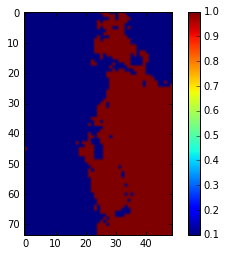

In [19]:
pl.imshow(pflag,vmin=0.1, vmax=1)
pl.colorbar()
print (np.unique(pflag))
#pl.plot(pflag)
pl.show()

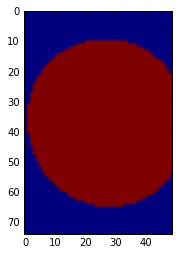

In [20]:
# SR Daten die nicht im GR Breich liegen werden entfernt
pl.imshow(wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad))

(74, 49, 2)
(74, 49)
((74, 49), (74, 49, 2))
((74, 49), (3626, 2))
[False  True]


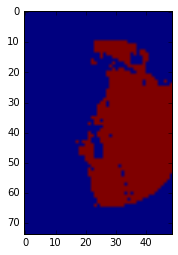

In [21]:
# Create ZonalData for spatial subsetting (inside GR range domain)

# get precip indexes
print(sr_xy.shape)
print(pflag.shape)

####################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#########!!!!!!!!!!!!!!!!!!!! eigentlich == 2 ===?????

precip_mask = (pflag >= 2) & wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad)

# get iscan/iray boolean arrays
print(precip_mask.shape, sr_xy.shape)
print(pflag.shape, sr_xy.reshape(-1, sr_xy.shape[-1]).shape)
pl.imshow(precip_mask)

#pl.colorbar()
print (np.unique(precip_mask))

# Parallax Correction
---------------------------

In [22]:
print("NRAY", nray_sr)
print("NBIN", ngate_sr)

# use localZenith Angle
alpha = sr_data['zenith']
beta = abs(-17.04 + np.arange(nray_sr) * bw_sr)

# Correct for parallax, get 3D-XYZ-Array
#   xyzp_sr: Parallax corrected xyz coordinates
#   r_sr_inv: range array from ground to SR platform
#   zp: SR bin altitudes
xyp_sr, r_sr_inv, z_sr = wrl.georef.correct_parallax(sr_xy, ngate_sr, dr_sr, alpha)
print(xyp_sr.shape, r_sr_inv.shape, z_sr.shape)
xyzp_sr = np.concatenate((xyp_sr, z_sr[..., np.newaxis]),
                   axis=-1)
print(sr_xy.shape)
print("SR_XYP:", xyp_sr.shape, xyzp_sr.shape, r_sr_inv.shape, z_sr.shape)

('NRAY', 49)
('NBIN', 176)
((74, 49, 176, 2), (176,), (74, 49, 176))
(74, 49, 2)
('SR_XYP:', (74, 49, 176, 2), (74, 49, 176, 3), (176,), (74, 49, 176))


('Hoehenunterschied mit ParallaxenKorr:', 6.219848990440369, 'meter')


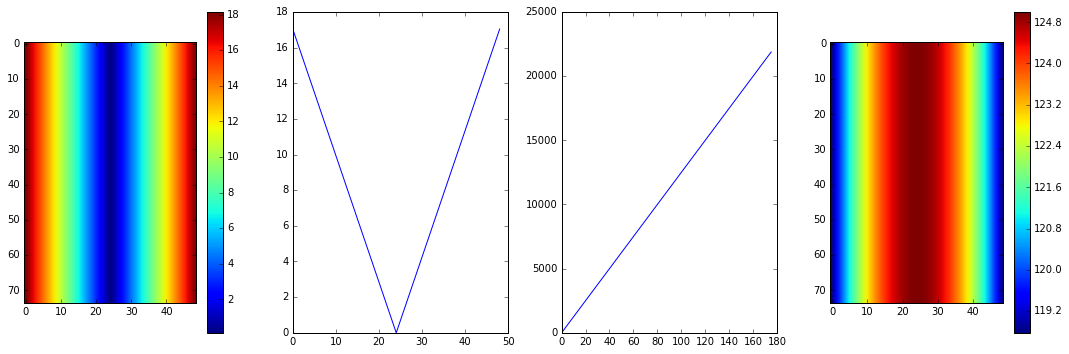

In [23]:
pl.figure(figsize=(15,5))
pl.subplot(1,4,1)
pl.imshow(alpha)
pl.colorbar()
pl.subplot(1,4,2)
pl.plot(beta)
pl.subplot(1,4,3)
pl.plot(r_sr_inv)
pl.subplot(1,4,4)
pl.imshow(z_sr[:,:,1])
pl.colorbar()
print('Hoehenunterschied mit ParallaxenKorr:',np.nanmax(z_sr[:,:,1])-np.nanmin(z_sr[:,:,1]),'meter')
pl.tight_layout()

# Compute spherical coordinates of SR bins with regard to GR
-------------------------------

((74, 49, 176), (74, 49, 176), (74, 49, 176))


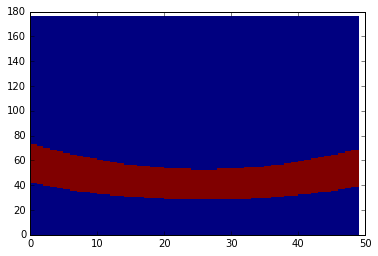

In [24]:
r_sr, az_sr, elev_sr = wrl.georef.xyz_to_spherical(xyzp_sr, alt0_gr, proj=rad)
print (r_sr.shape, az_sr.shape, elev_sr.shape)

#from mpl_toolkits.mplot3d import Axes3D
#fig = pl.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
#pppl = ax.scatter(r_sr.ravel(), az_sr.ravel(), elev_sr.ravel(), edgecolors='none')

####################################################################################??????????????????????????????
#TODO: hardcoded 1.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
mask = (elev_sr > (1.0 - bw_gr/2.)) & (elev_sr < (1.0 + bw_gr/2.))################### Das wird nirgendwo benutzt ?!??!
pl.figure()
pl.pcolormesh((mask[1,:,:].T))
mask.shape
pl.show()

# Compute SR and GR pulse volumes
------------------------------------

## Calculate distance from orbit $r_s$

(74, 49, 176)


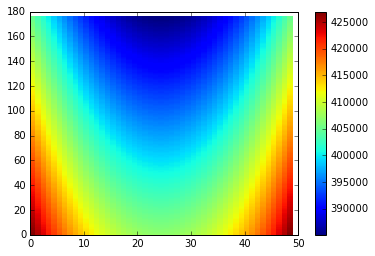

In [25]:
rs = wrl.georef.dist_from_orbit(zt, alpha, beta, r_sr_inv, re1)
print(rs.shape)
pl.figure()
pl.pcolormesh((rs[1,:,:].T))
pl.colorbar()
pl.show()

# SR pulse volume
--------------------------------

(74, 49, 176)
2724972196.412569
(74, 49, 176)
('Min. difference (m3):', 57223.422050476074)
('Max. difference (m3): ', 70339.55933856964)
('Average rel. difference (%):', 0.0026)
(74, 49, 176)
CPU times: user 247 ms, sys: 24.7 ms, total: 272 ms
Wall time: 241 ms


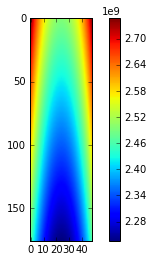

In [26]:
%%time
# Small anngle approximation
vol_sr2  = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.)**2
print(vol_sr2.shape)
print(vol_sr2[1,1,1])


# Or using wradlib's native function
vol_sr = wrl.qual.pulse_volume(rs, dr_sr, bw_sr)
print(vol_sr2.shape)

# Evaluate difference between both approaches
print("Min. difference (m3):", (vol_sr - vol_sr2).min())
print("Max. difference (m3): ", (vol_sr - vol_sr2).max())
print("Average rel. difference (%):", round(np.mean(vol_sr-vol_sr2)*100./np.mean(np.mean(vol_sr2)), 4))

# Verdict: differences are negligble - use wradlibs's native function!

print (vol_sr.shape)

pl.imshow(vol_sr[20,:,:].T)
pl.colorbar()

# GR Pulse Volume
----------------------------------

(360, 600)


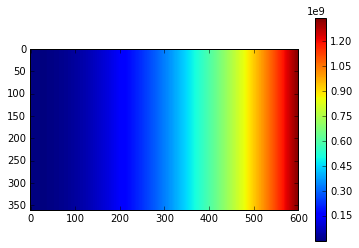

In [27]:


# GR pulse volumes
#   along one beam
vol_gr = wrl.qual.pulse_volume(r_gr, dr_gr, bw_gr)
#   with shape (nray_gr, ngate_gr)
vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

print (vol_gr.shape)
pl.imshow(vol_gr)
pl.colorbar()

# Calculate horizontal and vertical dimensions $R_S$ and $D_S$ of SR bin
---------------------------------

((74, 49, 176), (74, 49, 176))


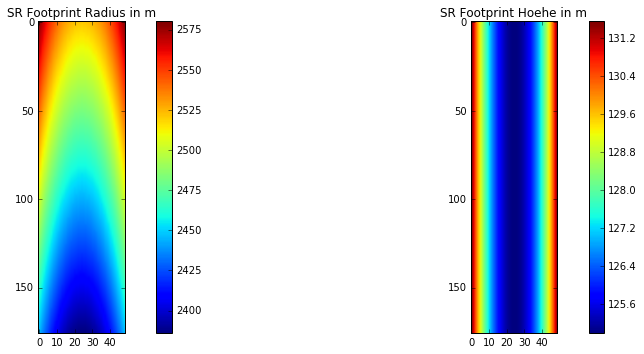

In [28]:
# Rs? HORIZONTAL SR Dimension
Rs = 0.5 * (1 +  np.cos(np.radians(alpha)))[:,:,np.newaxis] * rs * np.tan(np.radians(bw_sr/2.))

# Ds? Vertical SR Dimension
Ds = dr_sr / np.cos(np.radians(alpha))
Ds = np.broadcast_to(Ds[..., np.newaxis], Rs.shape)

print (Rs.shape, Ds.shape)

pl.figure(figsize=(15,5))
pl.subplot(1,2,1)
pl.imshow(Rs[20,:,:].T)
pl.colorbar()
pl.title('SR Footprint Radius in m')

pl.subplot(1,2,2)
pl.imshow(Ds[20,:,:].T)
pl.colorbar()
pl.title('SR Footprint Hoehe in m')

pl.tight_layout()

# Median Brightband Width/Height
----------------------------

(74, 49, 176)
((74, 49), (74, 49), (74, 49))
(74, 49, 176)
('ibb:', (74, 49))
(-4.333824623372883, -4.23866009392712)


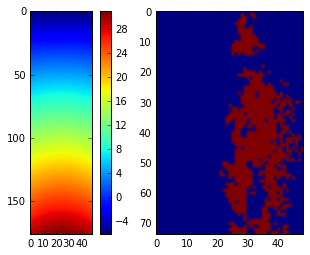

In [29]:

print(z_sr.shape)
print(sr_data['zbb'].shape, sr_data['bbwidth'].shape, sr_data['quality'].shape)
ratio, ibb = wrl.qual.get_bb_ratio(sr_data['zbb'], sr_data['bbwidth'], sr_data['quality'], z_sr)
print(ratio.shape)
print('ibb:', ibb.shape)
zbb = sr_data['zbb'].copy()
zbb[~ibb] = np.nan
print(np.nanmin(ratio[..., 9]), np.nanmax(ratio[..., 9]))

pl.subplot(1,2,1)
pl.imshow(ratio[20,:,:].T)
pl.colorbar()
pl.subplot(1,2,2)
pl.imshow(ibb)


# Convert SR Ku in S-Band Ref and vice versa
----------------------------------

In [30]:
 ##############
##############
### synthetic#
##############
##############
ref_sr = sr_data['refl'].filled(np.nan)
#ref_sr1 = np.ma.getdata(sr_data['refl'].filled(1))
#ref_sr = np.ones(ref_sr1.shape)*30

print(ref_sr.shape, ratio.shape)

'''
Hier ein eigenes Convert zwischen KU und X BAND
'''

((74, 49, 176), (74, 49, 176))


'\nHier ein eigenes Convert zwischen KU und X BAND\n'

# Matching SR / GR
------------------

((74, 49, 176), (74, 49))
(226,)
(226,)
(74, 49, 176)
(74, 49)
226


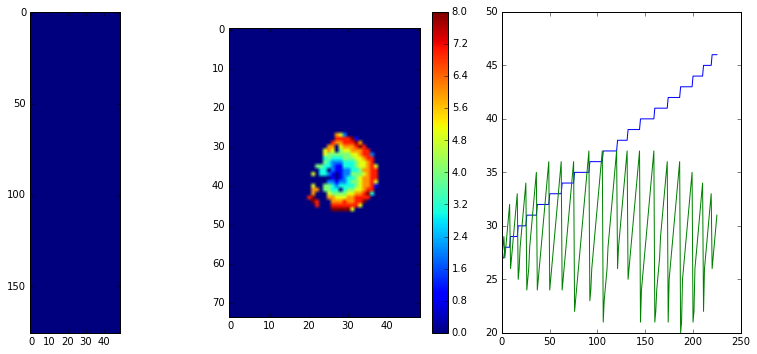

In [31]:
# First assumption: no valid SR bins (all False)
valid = np.asarray(elev_sr, dtype=np.bool)==False
print(valid.shape, precip_mask.shape)

# SR is inside GR range and is precipitating
iscan = precip_mask.nonzero()[0]
iray = precip_mask.nonzero()[1]
valid[iscan,iray] = True

# SR bins intersect with GR sweep
valid = valid & (elev_sr >= (elev_gr-bw_gr/2.)) & (elev_sr <= (elev_gr+bw_gr/2.))

# Number of matching SR bins per profile
nvalids = np.sum(valid, axis=2)

# scan and ray indices for profiles with at least one valid bin
vscan, vray = np.where(nvalids>0)

# number of profiles with at least one valid bin
nprof = len(vscan)

print(vscan.shape)
print(vray.shape)

print(valid.shape)
print(nvalids.shape)
print(nprof)

pl.figure(figsize=(15,5))
pl.subplot(1,4,1)
pl.imshow(valid[20,:,:].T)

pl.subplot(1,4,2)
pl.imshow(nvalids)
pl.colorbar()

pl.subplot(1,4,3)
pl.plot(vscan)
pl.plot(vray)


pl.tight_layout()

(74, 49, 176, 3)
((226, 3), (74, 49), (226,))
(226,)
(226,)
(226,)


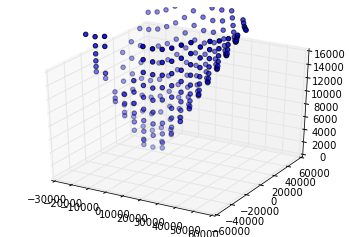

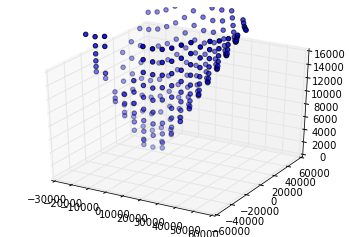

In [32]:
# average coordinates
xyz_v1 = xyzp_sr.copy()
print(xyz_v1.shape)
xyz_v1[~valid] = np.nan
xyz_c1 = xyzp_sr.copy()
xyz_c1[~valid] = 0
c = np.count_nonzero(xyz_c1[..., 0], axis=2)
ntotsr = c[vscan, vray]
xyz_m1 = np.nanmean(xyz_v1,axis=2)
xyz = xyz_m1[vscan, vray]
print(xyz.shape, c.shape, ntotsr.shape)

# approximate Rs
rs_v1 = Rs.copy()
rs_v1[~valid] = np.nan
rs_m1 = np.nanmax(rs_v1, axis=2)
rs_prof = rs_m1[vscan, vray]
ds = rs_prof
print(ds.shape)

# approximate Ds
ds_v1 = Ds.copy()
ds_v1[~valid] = np.nan
ds_m1 = np.nansum(ds_v1, axis=2)
ds_prof = ds_m1[vscan, vray]
dz = ds_prof
print(dz.shape)

# approximate Vs
vs_v1 = vol_sr.copy()
vs_v1[~valid] = np.nan
vs_m1 = np.nansum(vs_v1, axis=2)
vs_prof = vs_m1[vscan, vray]
volsr1 = vs_prof
print(volsr1.shape)

from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
pppl = ax.scatter(xyz_m1[..., 0], xyz_m1[..., 1], xyz_m1[..., 2])
#fig.colorbar(pppl, shrink=0.5, aspect=5)
ax.set_zlim(0, 16000)
pl.show()

fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
pppl = ax.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2])
#fig.colorbar(pppl, shrink=0.5, aspect=5)
ax.set_zlim(0, 16000)
pl.show()

In [33]:
#average coordinates
print (xyz_v1.shape, xyz_m1.shape, xyz.shape)
##### <<<<<<<<<<<-------------- Niedrigster Z Punkt bei 1873 meter ????
print (np.nanmin(xyz_v1[...,2]), np.nanmin(xyz_m1[...,2]), np.nanmin(xyz[...,2]))

((74, 49, 176, 3), (74, 49, 3), (226, 3))
(1873.5761940479279, 1873.5761940479279, 1873.5761940479279)


# Calculate spherical coordinates of SR sample volume with respect to GR
--------------------------------------------

In [34]:
r_sr, az_sr, el_rs = wrl.georef.xyz_to_spherical(xyz, alt0_gr, proj=rad)
print (r_sr.shape, az_sr.shape, el_rs.shape)

"""fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
xx=r_sr * np.cos(np.deg2rad(az_sr)) * np.sin(np.deg2rad(el_rs))
yy=r_sr * np.sin(np.deg2rad(az_sr)) * np.sin(np.deg2rad(el_rs))
zz=r_sr * np.cos(np.deg2rad(el_rs))
pppl = ax.scatter(xx,yy,zz)
#fig.colorbar(pppl, shrink=0.5, aspect=5)
ax.set_zlim(0, 40000)
pl.show()"""

((226,), (226,), (226,))


"fig = pl.figure()\nax = fig.add_subplot(111, projection='3d')\nxx=r_sr * np.cos(np.deg2rad(az_sr)) * np.sin(np.deg2rad(el_rs))\nyy=r_sr * np.sin(np.deg2rad(az_sr)) * np.sin(np.deg2rad(el_rs))\nzz=r_sr * np.cos(np.deg2rad(el_rs))\npppl = ax.scatter(xx,yy,zz)\n#fig.colorbar(pppl, shrink=0.5, aspect=5)\nax.set_zlim(0, 40000)\npl.show()"

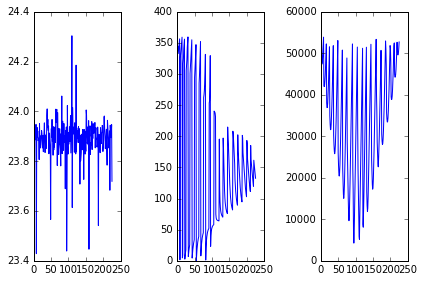

In [35]:
pl.subplot(1,3,1)
pl.plot(el_rs)
pl.subplot(1,3,2)
pl.plot(az_sr)
pl.subplot(1,3,3)
pl.plot(r_sr)
pl.tight_layout()

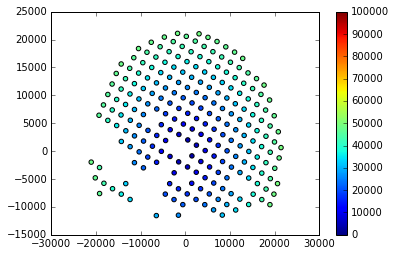

In [36]:
#????????????????? 45000m ???????????????????????????????????????????
fig = pl.figure()
xx=r_sr * np.cos(np.deg2rad(az_sr)) * np.sin(np.deg2rad(el_rs))
yy=r_sr * np.sin(np.deg2rad(az_sr)) * np.sin(np.deg2rad(el_rs))
zz=r_sr * np.cos(np.deg2rad(el_rs))
pl.scatter(xx,yy, c=zz, vmin=0, vmax=100000)
#fig.colorbar(pppl, shrink=0.5, aspect=5)
#ax.set_zlim(0, 16000)
pl.colorbar()
pl.show()

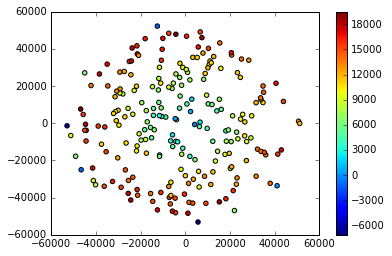

In [37]:
fig = pl.figure()
xx=r_sr * np.cos(az_sr) * np.sin(el_rs)
yy=r_sr * np.sin(az_sr) * np.sin(el_rs)
zz=r_sr * np.cos(el_rs)
pl.scatter(xx,yy, c=zz)
#fig.colorbar(pppl, shrink=0.5, aspect=5)
#ax.set_zlim(0, 16000)
pl.colorbar()
pl.show()

# Average SR reflectivity
------------------------------------------

In [38]:


ref_sr_1 = wrl.trafo.idecibel(ref_sr)
ref_sr_1[~valid] = np.nan
refsr1a = np.nanmean(ref_sr_1, axis=2)[vscan,vray]
refsr1a = wrl.trafo.decibel(refsr1a)

#ref_sr_2 = wrl.trafo.idecibel(ref_sr_ss)
#ref_sr_2[~valid] = np.nan
#refsr2a = np.nanmean(ref_sr_2, axis=2)[vscan,vray]
#refsr2a = wrl.trafo.decibel(refsr2a)

#ref_sr_3 = wrl.trafo.idecibel(ref_sr_sh)
#ref_sr_3[~valid] = np.nan
#refsr3a = np.nanmean(ref_sr_3, axis=2)[vscan,vray]
#refsr3a = wrl.trafo.decibel(refsr3a)


print(refsr1a.shape)



(226,)


# Identify which GR bins actually intersect with the SR footprint
---------------------
## Create Zonal Data Source of matching SR profile

In [39]:
zds = wrl.zonalstats.DataSource(xyz[:, 0:2].reshape(-1, 2), rad)
print(zds.ds.GetLayer().GetFeatureCount())

226


# Create SR beam polygons using R
--------------------------

In [40]:
tmp_trg_lyr = zds.ds.GetLayer()
trg_poly = []
for i, feat in enumerate(tmp_trg_lyr):
    geom = feat.GetGeometryRef().Buffer(rs_prof[i])
    poly = wrl.georef.ogr_to_numpy(geom)
    trg_poly.append(poly)

# Create ZonalDataPoly for GR and SR profiles
------------------------

In [41]:
%%time
print("creating")
zdp = wrl.zonalstats.ZonalDataPoly(gr_poly[..., 0:2].reshape(-1, 5, 2), trg_poly, srs=rad)
#zdp.dump_vector('m3d_zonal_poly_{0}'.format(platf))

creating
CPU times: user 26.2 s, sys: 219 ms, total: 26.4 s
Wall time: 26.2 s


In [42]:
%%time
print("loading")
#obj3 = wrl.zonalstats.GridCellsToPoly('m3d_zonal_poly_{0}'.format(platf))
obj3 = wrl.zonalstats.GridCellsToPoly(zdp)

loading
CPU times: user 16.9 s, sys: 175 ms, total: 17.1 s
Wall time: 16.9 s


# Average GR volume and reflectivity
---------------------------

In [43]:
%%time
print(obj3.ix.shape)
volgr1 = np.array([np.sum(vol_gr.ravel()[obj3.ix[i]])
                   for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
print(volgr1.shape)

ref_gr_i = wrl.trafo.idecibel(ref_gr.ravel())
#ref_gr_ku_i = wrl.trafo.idecibel(ref_gr_ku.ravel())
refgr1a = np.array([np.nanmean(ref_gr_i[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
refgr1a = wrl.trafo.decibel(refgr1a)
#refgr2a = np.array([np.nanmean(ref_gr_ku_i[obj3.ix[i]])
#             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
#refgr2a = wrl.trafo.decibel(refgr2a)

(226,)
(226,)
CPU times: user 218 ms, sys: 4.09 ms, total: 222 ms
Wall time: 219 ms


In [44]:
##### betrachten von noederschlags relevanten Reflek und Threshold DPR Ku = 15 DBZ
from satlib import corcor

# Threshold festlegen
---------------------------------

In [45]:
TH = 15
refsr1a[refsr1a<=TH]=np.nan
refgr1a[refgr1a<=TH]=np.nan
ref_gr[ref_gr<=TH]=np.nan
ref_sr[ref_sr<=TH]=np.nan

# PLOT
______________

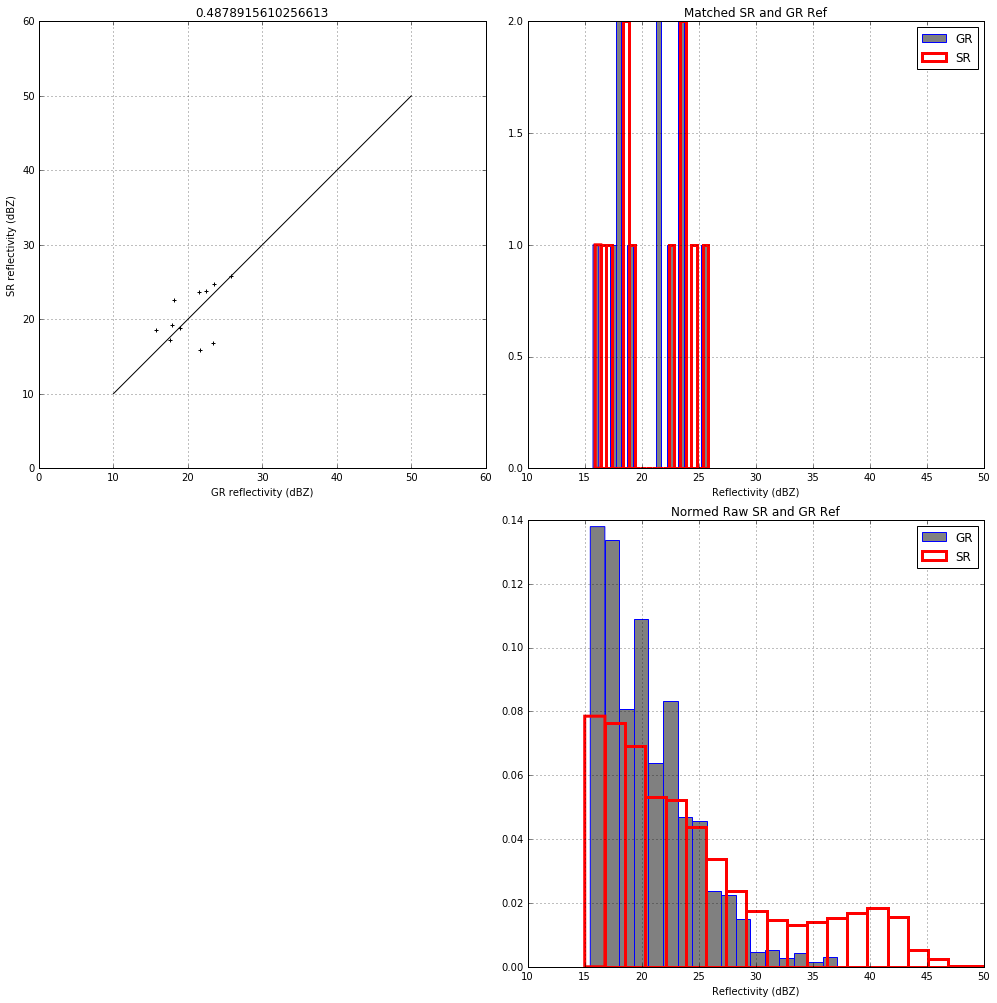

In [46]:
fig = pl.figure(figsize=(14,14))
ax = fig.add_subplot(221, aspect="equal")
pl.scatter(refgr1a, refsr1a, marker="+", c="black")
pl.plot([10,50],[10,50], linestyle="solid", color="black")
#pl.xlim(10,50)
#pl.ylim(10,50)
pl.grid()
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
pl.title(corcor(refgr1a, refsr1a))

ax = fig.add_subplot(222)
m1 = ~np.isnan(refgr1a)& ~np.isnan(refsr1a)

pl.hist(refgr1a[m1], bins=20, edgecolor="blue", facecolor="grey", label="GR")
pl.hist(refsr1a[m1], bins=20, edgecolor="red", facecolor="None", label="SR", lw=3)
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.title('Matched SR and GR Ref')
pl.xlim(10,50)

ax = fig.add_subplot(224)
r_gr = ref_gr.reshape(ref_gr.shape[0]*ref_gr.shape[1])
r_sr = ref_sr.reshape(ref_sr.shape[0]*ref_sr.shape[1]*ref_sr.shape[2])
m1, m2 = ~np.isnan(r_gr), ~np.isnan(r_sr)

pl.hist(r_gr[m1], bins=20, edgecolor="blue", facecolor="grey", label="GR", normed=1)
pl.hist(r_sr[m2], bins=20, edgecolor="red", facecolor="None", label="SR", lw=3, normed=1)
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.title('Normed Raw SR and GR Ref')
pl.xlim(10,50)
#fig.suptitle("uncorrected GR vs uncorrected SR")

pl.tight_layout()
pl.show()

In [47]:
"""fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(-50000, 50000)
pl.ylim(-50000, 50000)
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refgr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(-50000, 50000)
pl.ylim(-50000, 50000)
pl.grid()
pl.colorbar(shrink=0.5)
fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a-refgr1a,vmin=-5,vmax=5 ,edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(-50000, 50000)
pl.ylim(-50000, 50000)
pl.grid()
pl.colorbar(shrink=0.5)
fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.show()"""

'fig = pl.figure(figsize=(12,8))\nax = fig.add_subplot(131, aspect="equal")\npl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")\npl.title("SR reflectivity")\npl.xlim(-50000, 50000)\npl.ylim(-50000, 50000)\npl.grid()\npl.colorbar(shrink=0.5)\n\nax = fig.add_subplot(132, aspect="equal")\npl.scatter(xyz[..., 0], xyz[...,1], c=refgr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")\npl.title("GR reflectivity")\npl.xlim(-50000, 50000)\npl.ylim(-50000, 50000)\npl.grid()\npl.colorbar(shrink=0.5)\nfig.suptitle("uncorrected GR vs uncorrected SR")\npl.tight_layout()\n\nax = fig.add_subplot(133, aspect="equal")\npl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a-refgr1a,vmin=-5,vmax=5 ,edgecolor="None")\npl.title("GR reflectivity")\npl.xlim(-50000, 50000)\npl.ylim(-50000, 50000)\npl.grid()\npl.colorbar(shrink=0.5)\nfig.suptitle("uncorrected SR - GR")\npl.tight_layout()\npl.show()'

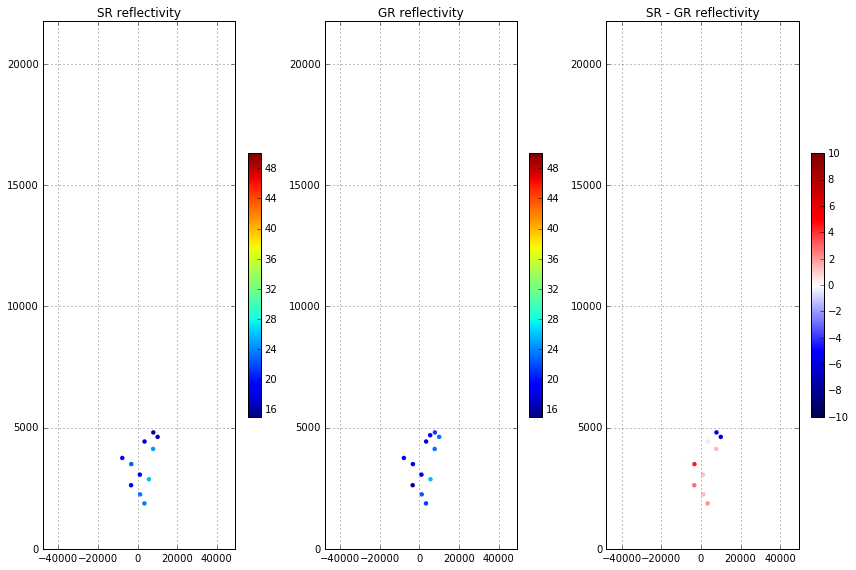

In [48]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="auto")
pl.scatter(xyz[..., 1], xyz[...,2], c=refsr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(np.nanmin(xyz[...,1]),np.nanmax(xyz[...,1]))
pl.ylim(0,np.nanmax(xyz[...,2]))
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="auto")
pl.scatter(xyz[..., 1], xyz[...,2], c=refgr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(np.nanmin(xyz[...,1]),np.nanmax(xyz[...,1]))
pl.ylim(0,np.nanmax(xyz[...,2]))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="auto")
pl.scatter(xyz[..., 1], xyz[...,2], c=refsr1a-refgr1a, cmap='seismic',vmin=-10,vmax=10 ,edgecolor="None")
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(xyz[...,1]),np.nanmax(xyz[...,1]))
pl.ylim(0,np.nanmax(xyz[...,2]))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.show()

# ????? Wie groß ist der Fehler in unseren Breiten zwischen 3d Korrigier und nicht korrigiert ???

('Corellation: ', '0.4878915610256613')


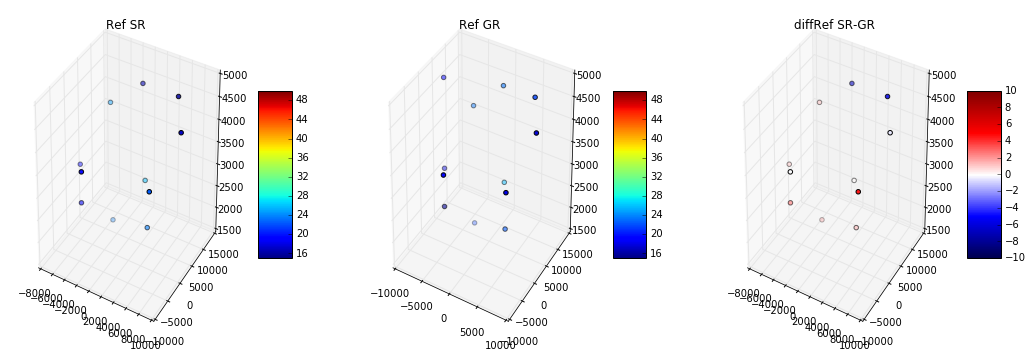

In [49]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(18,6))
ax1 = fig.add_subplot(131, projection='3d')
pppl = ax1.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2], c=refsr1a.ravel(), vmin=TH, vmax=50)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax1.set_title('Ref SR')

ax2 = fig.add_subplot(132, projection='3d')
pppl = ax2.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2], c=refgr1a.ravel(), vmin=TH, vmax=50)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax2.set_title('Ref GR')

ax3 = fig.add_subplot(133, projection='3d')
pppl = ax3.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2], c=refsr1a.ravel()-refgr1a.ravel(),
                   cmap='seismic',vmin=-10,vmax=10)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax3.set_title('diffRef SR-GR')

from satlib import corcor
print ('Corellation: ',corcor( refgr1a, refsr1a))
pl.show()

In [50]:
"""ax = fig.add_subplot(111)
GRi, SRi = refgr1a, refsr1a
mmi = ~np.isnan(GRi)& ~np.isnan(SRi)

pl.hist(SRi[mmi]-GRi[mmi],bins=50, facecolor="grey", alpha=0.6)
pl.axvline(np.mean(SRi[mmi]-GRi[mmi]), color='blue', label='Mean diff')
pl.axvline(np.median(SRi[mmi]-GRi[mmi]), color='green', label='Median diff')
pl.axvline(0, color='black',ls='--',lw=3)

xmin, xmax = np.nanmin(SRi[mmi]-GRi[mmi]), np.nanmax(SRi[mmi]-GRi[mmi])
limits = np.nanmax([abs(xmin),abs(xmax)])
pl.xlim(-limits,limits)

pl.title('Diff SR-GR, bias: '+str( np.sum(SRi[mmi]-GRi[mmi])/len(SRi[mmi]-GRi[mmi]))+' dbz')
pl.grid()
pl.legend()
pl.xlabel('GR overestimate----------------------------Diff in dbz----------------------------SR overestimate')
pl.ylabel('number')"""

'ax = fig.add_subplot(111)\nGRi, SRi = refgr1a, refsr1a\nmmi = ~np.isnan(GRi)& ~np.isnan(SRi)\n\npl.hist(SRi[mmi]-GRi[mmi],bins=50, facecolor="grey", alpha=0.6)\npl.axvline(np.mean(SRi[mmi]-GRi[mmi]), color=\'blue\', label=\'Mean diff\')\npl.axvline(np.median(SRi[mmi]-GRi[mmi]), color=\'green\', label=\'Median diff\')\npl.axvline(0, color=\'black\',ls=\'--\',lw=3)\n\nxmin, xmax = np.nanmin(SRi[mmi]-GRi[mmi]), np.nanmax(SRi[mmi]-GRi[mmi])\nlimits = np.nanmax([abs(xmin),abs(xmax)])\npl.xlim(-limits,limits)\n\npl.title(\'Diff SR-GR, bias: \'+str( np.sum(SRi[mmi]-GRi[mmi])/len(SRi[mmi]-GRi[mmi]))+\' dbz\')\npl.grid()\npl.legend()\npl.xlabel(\'GR overestimate----------------------------Diff in dbz----------------------------SR overestimate\')\npl.ylabel(\'number\')'

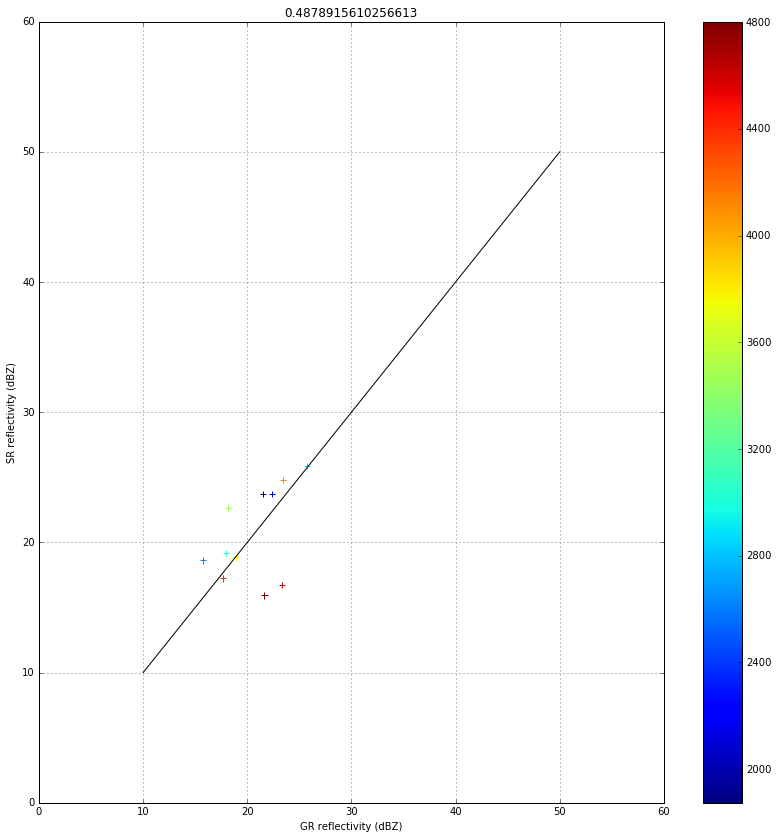

In [51]:
pl.figure(figsize=(14,14))
pl.scatter(refgr1a, refsr1a, c=xyz[...,2],marker="+",s=40 )
pl.plot([10,50],[10,50], linestyle="solid", color="black")
pl.colorbar()
#pl.xlim(10,50)
#pl.ylim(10,50)
pl.grid()
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
pl.title(corcor(refgr1a, refsr1a))

In [52]:
refgr1a.shape

(226,)

In [53]:
xyz.shape

(226, 3)

In [54]:
2.8*40

112.0

In [55]:
1./600.

0.0016666666666666668

In [56]:
"""pl.pcolormesh(sr_data["lon"], sr_data["lat"], ref_sr[:,:,10], vmin=0, vmax=40, cmap='jet')
pl.colorbar()
pl.figure()

ax, pm = wrl.vis.plot_ppi(ref_gr, vmin=0, vmax=40, cmap='jet')
cbar = pl.colorbar(pm, shrink=0.75)
cbar.set_label("Reflectivity (dBZ)")

pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.scatter(xyz[...,0], xyz[...,1], c=refsr1a, label=str(elev_gr),vmin=0, vmax=40, s=40)
pl.colorbar();pl.xlim(-150000,150000);pl.ylim(-150000,150000)
pl.subplot(1,2,2)
pl.scatter(xyz[...,0], xyz[...,1], c=refgr1a, label=str(elev_gr),vmin=0, vmax=40, s=40)
pl.colorbar();pl.xlim(-150000,150000);pl.ylim(-150000,150000)
pl.show()
        """

'pl.pcolormesh(sr_data["lon"], sr_data["lat"], ref_sr[:,:,10], vmin=0, vmax=40, cmap=\'jet\')\npl.colorbar()\npl.figure()\n\nax, pm = wrl.vis.plot_ppi(ref_gr, vmin=0, vmax=40, cmap=\'jet\')\ncbar = pl.colorbar(pm, shrink=0.75)\ncbar.set_label("Reflectivity (dBZ)")\n\npl.figure(figsize=(10,5))\npl.subplot(1,2,1)\npl.scatter(xyz[...,0], xyz[...,1], c=refsr1a, label=str(elev_gr),vmin=0, vmax=40, s=40)\npl.colorbar();pl.xlim(-150000,150000);pl.ylim(-150000,150000)\npl.subplot(1,2,2)\npl.scatter(xyz[...,0], xyz[...,1], c=refgr1a, label=str(elev_gr),vmin=0, vmax=40, s=40)\npl.colorbar();pl.xlim(-150000,150000);pl.ylim(-150000,150000)\npl.show()\n        '

'pl.xlim(0,40000)\npl.ylim(0,400)'

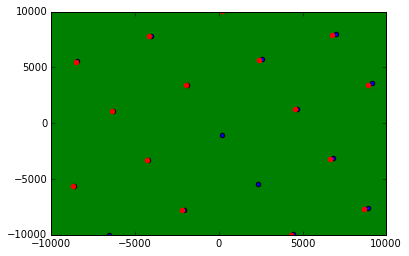

In [57]:
pl.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], color='green')
pl.scatter(sr_x,sr_y)

pl.scatter(xyz[...,0], xyz[...,1],color='red')

#pl.scatter(gr_polargrid[0],gr_polargrid[1])
#pl.scatter(sr_x,sr_y, color='green')
pl.xlim(-10000,10000)
pl.ylim(-10000,10000)


"""pl.xlim(0,40000)
pl.ylim(0,400)"""

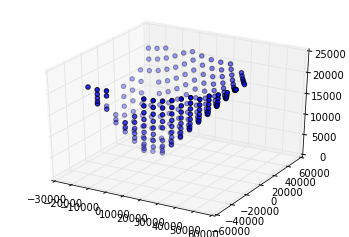

In [58]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
pppl = ax.scatter(xyz_m1[..., 0], xyz_m1[..., 1], xyz_m1[..., 2])
#pl.savefig('/automount/ftp/velibor/validation/MATCHINGPROB1.pdf')
pl.show()

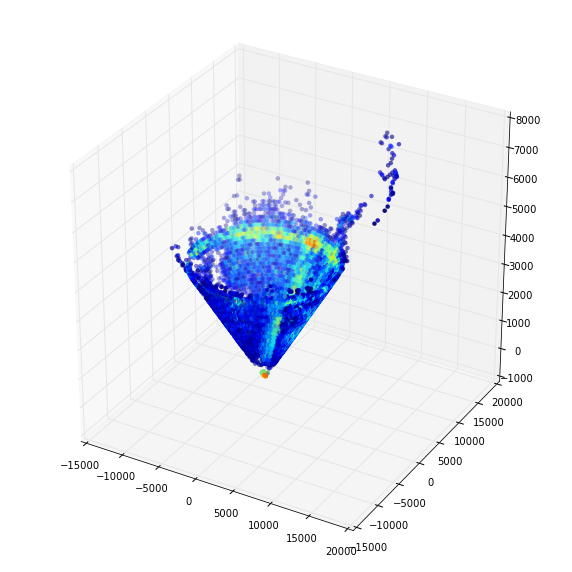

In [59]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pppl = ax.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], gr_xyz[:,:,2],c=ref_gr, edgecolors='none')
pl.show()

((226, 3), (226,))


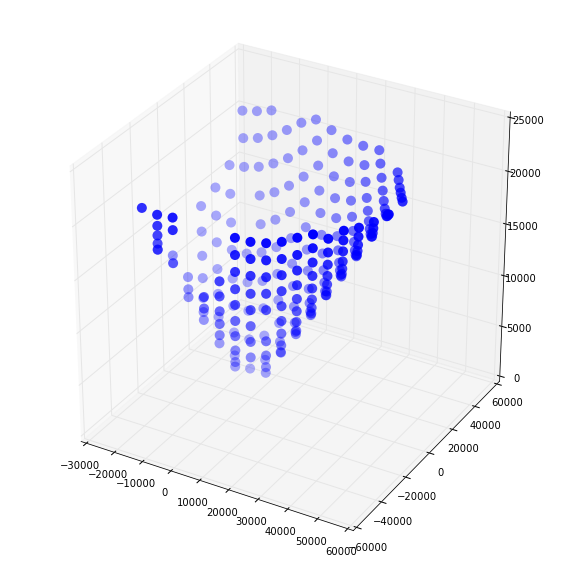

In [60]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
print(xyz.shape, refsr1a.shape)
pppl = ax.scatter(xyz[...,0],xyz[...,1],xyz[...,2], edgecolors='none', s=100, color='black')

pl.show()

((226, 3), (226,))


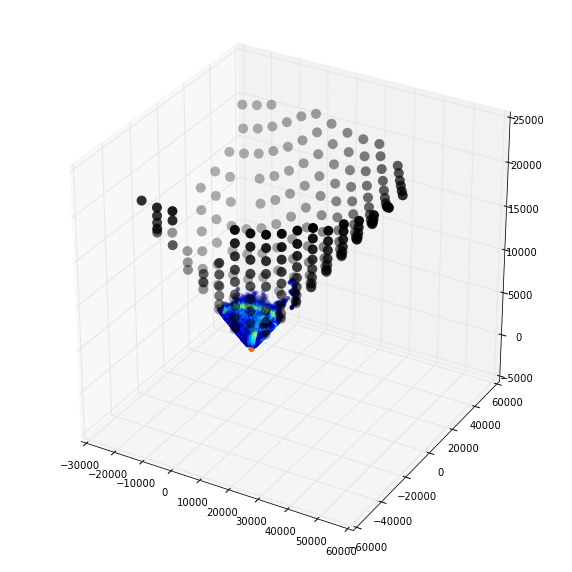

In [61]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
print(xyz.shape, refsr1a.shape)
pppl = ax.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], gr_xyz[:,:,2],c=ref_gr, edgecolors='none')
pppl = ax.scatter(xyz[...,0],xyz[...,1],xyz[...,2], edgecolors='none', s=100, c='black')
#ax.set_xlim(-10000, 10000)
#ax.set_ylim(-10000, 10000)
#ax.set_zlim(0, 10000)
pl.show()

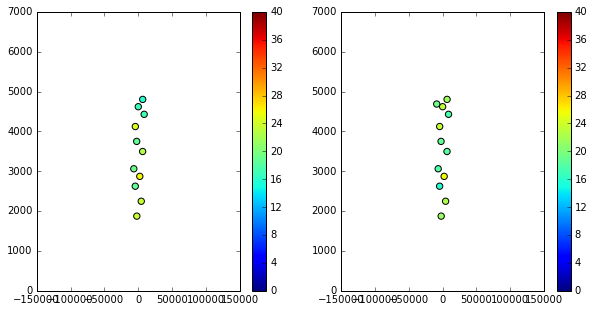

In [62]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.scatter(xyz[...,0], xyz[...,2], c=refsr1a, label=str(elev_gr),vmin=0, vmax=40, s=40)
pl.colorbar();pl.xlim(-150000,150000);pl.ylim(0,7000)
pl.subplot(1,2,2)
pl.scatter(xyz[...,0], xyz[...,2], c=refgr1a, label=str(elev_gr),vmin=0, vmax=40, s=40)
pl.colorbar();pl.xlim(-150000,150000);pl.ylim(0,7000)
pl.show()
        

# Former Methode usig Loop

In [63]:
# Lots of containers to store samples (only for one GR sweep angle!)
x = np.zeros(nprof)*np.nan        # x coordinate of sample
y = np.zeros(nprof)*np.nan        # y coordinate of sample
z = np.zeros(nprof)*np.nan        # z coordinate of sample
dz = np.zeros(nprof)*np.nan       # depth of sample
ds = np.zeros(nprof)*np.nan       # width of sample
rs = np.zeros(nprof)*np.nan       # range of sample from GR
refsr1 = np.zeros(nprof)*np.nan     # SR reflectivity
refsr2 = np.zeros(nprof)*np.nan     # SR reflectivity (S-band, snow)
refsr3 = np.zeros(nprof)*np.nan     # SR reflectivity (S-band, hail)
refgr1 = np.zeros(nprof)*np.nan     # GR reflectivity
refgr2 = np.zeros(nprof)*np.nan     # GR reflectivity (Ku-band)
ntotpr = np.zeros(nprof,dtype="i4")# total number of SR bins in sample
nrej1 = np.zeros(nprof,dtype="i4")# number of rejected SR bins in sample
ntotgr = np.zeros(nprof,dtype="i4")# total number of GR bins in sample
nrej2 = np.zeros(nprof,dtype="i4")# number of rejected GR bins in sample
iref1 = np.zeros(nprof)*np.nan    # path-integrated SR reflectivity
iref2 = np.zeros(nprof)*np.nan    # path-integrated GR reflectivity
stdv1 = np.zeros(nprof)*np.nan    # std. dev. of SR reflectivity in sample
stdv2 = np.zeros(nprof)*np.nan    # std. dev. of GR reflectivity in sample
volsr = np.zeros(nprof)*np.nan     # total volume of SR bins in sample
volgr = np.zeros(nprof)*np.nan     # total volume of GR bins in sample

In [64]:
%%time
# Loop over relevant SR profiles
for ii, (ss, rr)  in enumerate(zip(vscan,vray)):
    # Index and count valid bins in each profile
    ip = np.where(valid[ss,rr])[0]
    numbins = len(ip)
    ntotpr[ii]=numbins
    if numbins == 0:
        continue
    # Compute the mean position of these bins
    x[ii]=np.mean(xyzp_sr[ss,rr,ip,0])
    y[ii]=np.mean(xyzp_sr[ss,rr,ip,1])
    z[ii]=np.mean(xyzp_sr[ss,rr,ip,2])

    # Thickness of the layer
    dz[ii]=(numbins * dr_sr) / np.cos( np.radians(alpha[ss, rr]) )

    # SR averaging volume
    volsr[ii]=np.sum(vol_sr[ss, rr, ip])

    # Note mean TRMM beam diameter
    ds[ii]=np.radians(bw_sr) * np.mean( ( (zt-z[ii]) /
                                         np.cos( np.radians(alpha[ss, rr]) ) ) )
    # Note distance from radar
    s=np.sqrt(x[ii]**2+y[ii]**2)
    rs[ii]=(re2+z[ii]) * np.sin(s/re2) / np.cos(np.radians(elev_gr))

    # This should not be required because we applied ZonalData
    ### Check that sample is within radar range
    ##if r[ii,jj]+ds[ii,jj]/2. gt rmax then continue

    ## THIS IS THE ORIGINAL IDL CODE - IS THIS A BUG???
    ##ref1[ii,jj]=MEAN(ref_sr1,/nan)
    ##ref3[ii,jj]=MEAN(ref_sr2,/nan)
    ##ref4[ii,jj]=MEAN(ref_sr3,/nan)

    # Simple linear average of reflectivity
    #   - we can become fancier in the next step
    # ATTENTION: NEED TO FLIP ARRAY

    refsr1[ii]=np.nanmean(ref_sr[ss,rr,ip])
    #refsr2[ii]=np.nanmean(ref_sr_ss[ss,rr,ip])
    #refsr3[ii]=np.nanmean(ref_sr_sh[ss,rr,ip])

    ## Not sure why we need this...
    ### Note the number of rejected bins
    ##nrej1[ii,jj]=ROUND(TOTAL(FINITE(ref_sr1,/nan)))
    ##if FINITE(stdv1[ii,jj]) eq 0 and np-nrej1[ii,jj] gt 1 then STOP

    # SHOULD WE USE ZONALDATA INSTEAD? COULD BE MORE ACCURATE, BUT ALSO SLOWER
    # WE COULD BASICALLY START A NEW LOOP HERE AND RUN ZONALDATA BEFORE

    # Compute the horizontal distance to all the GR bins
    d = np.sqrt((gr_xyz[...,0]-x[ii])**2 + (gr_xyz[...,1]-y[ii])**2)

    # Find all GR bins within the SR beam
    aa, bb = np.where(d <= ds[ii]/2.)

    # Store the number of bins
    ntotgr[ii] = len(aa)

    if len(aa) == 0:
        continue

    # Extract the relevant GR bins

    # Compute the GR averaging volume
    volgr[ii]=np.sum(vol_gr[aa,bb])

    # Average over those bins that exceed the reflectivity threshold
    #   IDL code does exponential distance and volume weighting
    #   Let's try simple mean first,
    #   THEN ZonalStats!
    refgr1[ii]=np.nanmean(ref_gr[aa,bb])
    #refgr2[ii]=np.nanmean(ref_gr_ku[aa,bb])

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


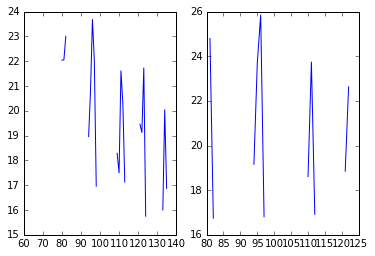

In [65]:
pl.subplot(1,2,1)
pl.plot(refgr1) 
pl.subplot(1,2,2)
pl.plot(refsr1) 

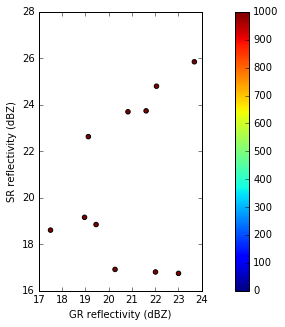

In [66]:

fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(111, aspect="equal")
pl.scatter(refgr1, refsr1, c=z, vmin=0,vmax=1000)
pl.colorbar()
#pl.plot([0,60],[0,60], linestyle="solid", color="black")
#pl.xlim(10,50)
#pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
#ax = fig.add_subplot(122)
#pl.hist(refgr1[refsr1>10], bins=np.arange(-10,50,5), edgecolor="None", label="GR")
#pl.hist(refsr1[refsr1>-10], bins=np.arange(-10,50,5), edgecolor="red", facecolor="None", label="SR")
#pl.xlabel("Reflectivity (dBZ)")
#pl.legend()
#fig.suptitle("uncorrected GR vs uncorrected SR")



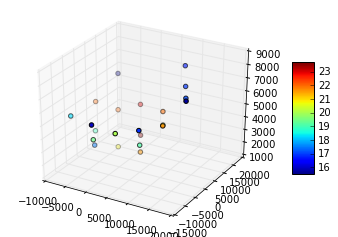

In [67]:
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

pppl = ax.scatter(x,y,z, c=refgr1)
fig.colorbar(pppl, shrink=0.5, aspect=5)
#ax.set_zlim(0, 40000)
pl.show()

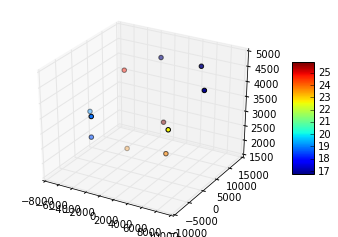

In [68]:
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

pppl = ax.scatter(x,y,z, c=refsr1)
fig.colorbar(pppl, shrink=0.5, aspect=5)
#ax.set_zlim(0, 40000)
pl.show()

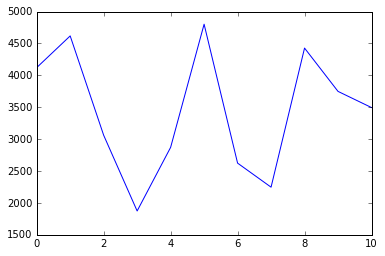

In [69]:
pl.plot(z[refsr1>0])

In [70]:
13.5/0.65

20.76923076923077